In [26]:
import numpy as np
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os, string
import pandas as pd

from ast import literal_eval

from process_predictions import get_predictions
from utils import assess_performance, flatten, compare_preds

import fasttext

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = os.path.join(
    "..",
    "..",
    "..",
    "..",
    "data",
    "frameworks_data",
    "subsectors",
    "training_data",
    "test_subsectors.csv",
)


test_df = pd.read_csv(DATA_PATH)
test_df["target"] = test_df["target"].apply(
    lambda x: [item for item in literal_eval(x)]
)

test_df.head(2)

,entry_id,original_language,target,excerpt
0,548488,en,[subsector->WASH->Water Supply],Many of them are in need of immediate medical ...
1,542146,en,[subsector->Protection->Sexual and Gender Base...,Difficulties in accessing basic goods and serv...


## postprocess raw predictions and get results

In [3]:
def get_predictions_all(ratio_proba_threshold, 
    nb_entries: int, 
    ratio_nb: int):
    
    predictions = []
    for entry_nb in range (nb_entries):
        
        returns_subsectors = ratio_proba_threshold[entry_nb] 
        
        subsectors_tags = {
           key: value for key, value in returns_subsectors.items()
        }
                    
        preds_subsectors = get_preds_entry (subsectors_tags, False, ratio_nb)
        predictions.append(preds_subsectors)
                
    return predictions
        


def get_preds_entry (preds_column, return_at_least_one=True, ratio_nb=1, return_only_one=False):
    preds_entry = [
        sub_tag for sub_tag in list(preds_column.keys()) if preds_column[sub_tag]>ratio_nb
    ]
    if return_only_one:
        preds_entry = [
            sub_tag for sub_tag in list(preds_column.keys())\
                if preds_column[sub_tag]==max(list(preds_column.values()))
        ]
    if return_at_least_one:
        if len(preds_entry)==0:
            preds_entry = [
                sub_tag for sub_tag in list(preds_column.keys())\
                    if preds_column[sub_tag]==max(list(preds_column.values()))
            ]
    return preds_entry

def get_predictions_df(doc):
    n_preds = len(doc['preds_test_set'])

    final_preds_subsectors = get_predictions_all(
        doc['preds_test_set'], 
        nb_entries=n_preds, 
        ratio_nb=0.9)

    predictions_df = test_df[[
    'excerpt', 'entry_id'
    ]]
        
    predictions_df['subsectors'] = final_preds_subsectors


    return predictions_df

sectors_treated = [
    "WASH",
    "Livelihoods",
    "Nutrition",
    "Health",
    "Protection",
    "Shelter",
    "Education",
]


## Distilled Model

In [4]:
pickle_file = open("logs/results_small_model_subsectors_14_july.pickle", "rb") ##NAME OF PICKLE FILE
doc = pickle.load(pickle_file)

In [5]:
len(doc['preds_test_set']), len(doc['preds_test_set'][0])

(14484, 31)

In [6]:
predictions_df = get_predictions_df(doc)
predictions_df.head()

,excerpt,entry_id,subsectors
0,Many of them are in need of immediate medical ...,548488,"[subsector->Health->Health care, subsector->WA..."
1,Difficulties in accessing basic goods and serv...,542146,[subsector->Protection->Sexual and Gender Base...
2,6. Status of Being Bitten by a Suspicious Anim...,534081,[subsector->Protection->Human rights]
3,When compared with rates of children receiving...,534116,[subsector->Health->Health status]
4,Distribution by rate of vaccination doesn’t sh...,534133,[subsector->Health->Health status]


In [7]:
test_df.head()

,entry_id,original_language,target,excerpt
0,548488,en,[subsector->WASH->Water Supply],Many of them are in need of immediate medical ...
1,542146,en,[subsector->Protection->Sexual and Gender Base...,Difficulties in accessing basic goods and serv...
2,534081,en,[subsector->Health->Health status],6. Status of Being Bitten by a Suspicious Anim...
3,534116,en,[subsector->Health->Health status],When compared with rates of children receiving...
4,534133,en,[subsector->Health->Health care],Distribution by rate of vaccination doesn’t sh...


In [8]:
raw_results = {}
tot_wrong_ids = {}
  
preds = compare_preds(test_df['target'].values, predictions_df['subsectors'])
        
results_col = preds['scores']
raw_results['subsectors'] = results_col
    
df_results_raw = pd.DataFrame.from_dict(raw_results, orient='columns')
df_results_raw['names'] = df_results_raw.index
df_results_raw 
#df_results_raw.iloc[[0, 3,4]]

,subsectors,names
proportion_at_leaset_one_missing,0.44,proportion_at_leaset_one_missing
proportion_at_least_one_false,0.57,proportion_at_least_one_false
proportion_perfect_matches,0.43,proportion_perfect_matches


In [9]:
results_subsectors = assess_performance(
    predictions_df["subsectors"],
    test_df["target"].tolist(),
    sorted(list(set(flatten(test_df["target"])))),
    "subsectors",
)
results_subsectors.index = results_subsectors.index.to_series().apply(
    lambda x: "->".join(x.split("->")[1:]) if "->" in x else x
)
results_subsectors = results_subsectors.sort_index()
results_subsectors


,binary_precision,binary_recall,binary_f1_score
Education->Learning Environment,0.708000,0.61500,0.658000
Education->Teachers and Education Personnel,0.651000,0.38400,0.483000
Education->Teaching and Learning,0.458000,0.49300,0.475000
Health->Health care,0.795000,0.70400,0.747000
Health->Health status,0.809000,0.63500,0.711000
Livelihoods->Expenditures,0.652000,0.26300,0.375000
Livelihoods->Income,0.741000,0.67100,0.704000
Livelihoods->Productive Assets,0.342000,0.17400,0.230000
Livelihoods->Skills & Qualifications,0.651000,0.43600,0.522000
Nutrition->Nutrition services,0.655000,0.40900,0.503000


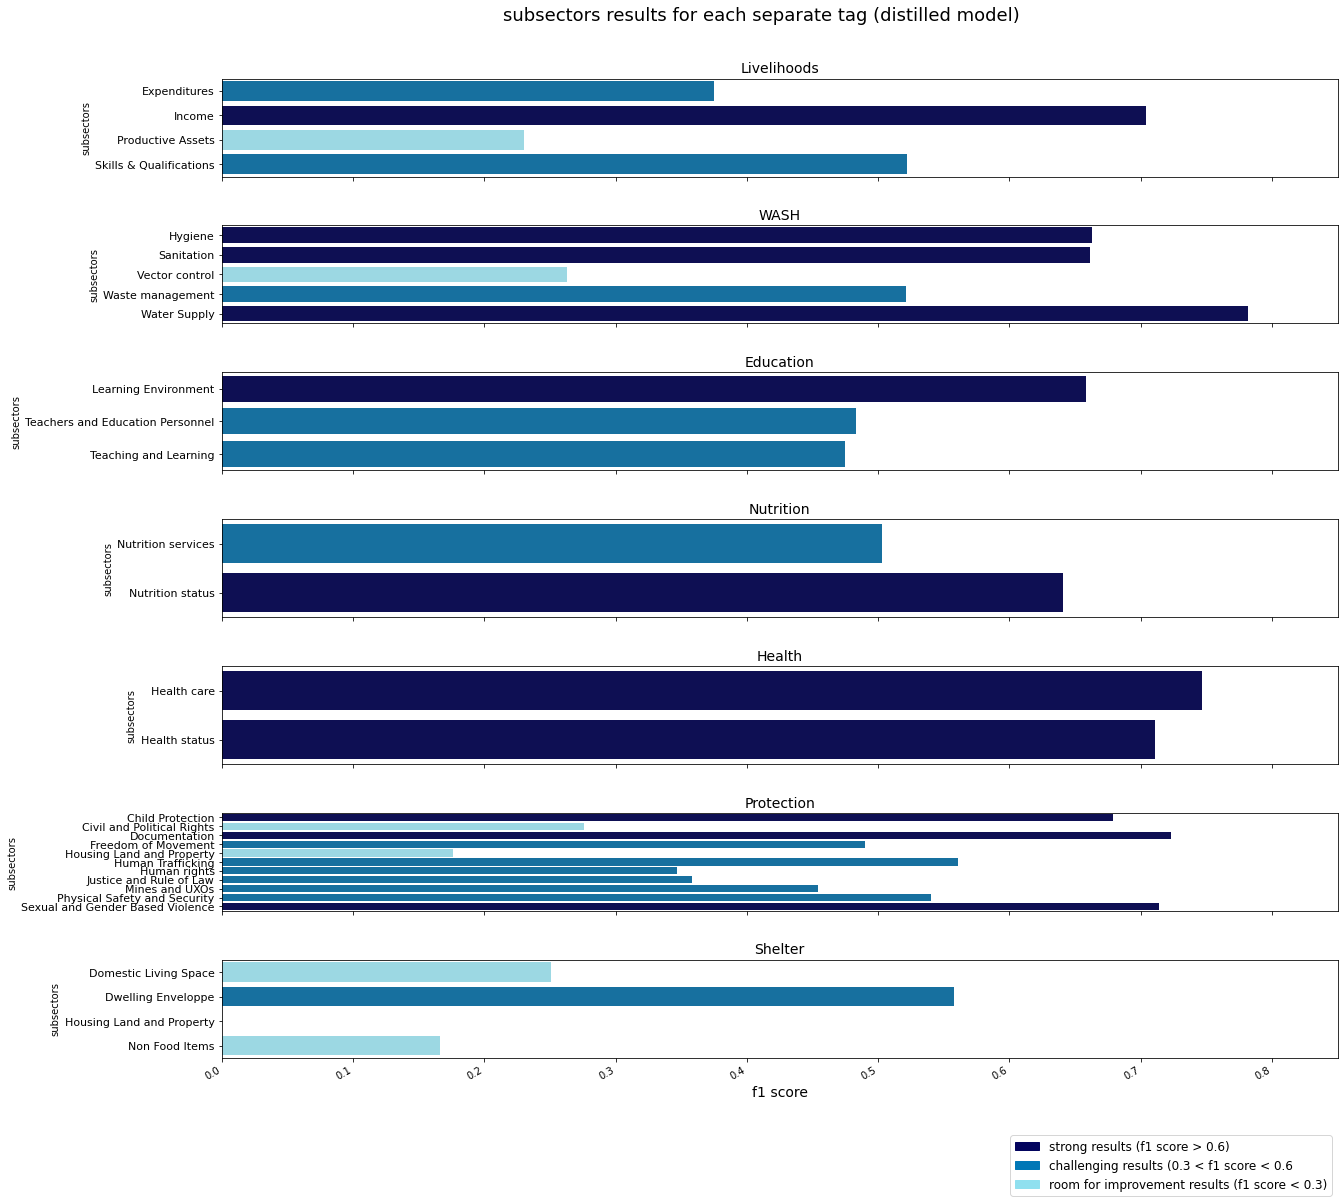

In [10]:
subsectors_vizu_df = results_subsectors.copy()
subsectors_vizu_df.drop(subsectors_vizu_df.tail(1).index,inplace=True)
subsectors_vizu_df.sort_values(by='binary_f1_score', inplace=True, ascending=False)

subsectors_vizu_df = subsectors_vizu_df[['binary_f1_score']]#.rename(columns={'1_f1_score': 'tag reliability'})
subsectors_vizu_df['tag_name'] = subsectors_vizu_df.index
subsectors_vizu_df['sectors'] = subsectors_vizu_df['tag_name'].apply(lambda x: x.split('->')[0])
subsectors_vizu_df['subsectors'] = subsectors_vizu_df['tag_name'].apply(lambda x: x.split('->')[1])

n_treated_sectors = len(sectors_treated)
fig, axes = plt.subplots(n_treated_sectors, 1, sharex=True, figsize=(20,20), facecolor='white')


def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = values 
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

custom_palette = {}
for v in list(subsectors_vizu_df['subsectors']):
    q = subsectors_vizu_df[subsectors_vizu_df['subsectors']==v]['binary_f1_score'].values[0]
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_sectors = {
 'WASH': 1,
 'Livelihoods': 0,
 'Nutrition': 3,
 'Health': 4,
 'Protection': 5,
 'Shelter': 6,
 'Education': 2
}

for j in range (n_treated_sectors):
    sector_tmp = sectors_treated[j]
    i = ordered_sectors[sector_tmp]
    subsectors_tmp = results_subsectors[results_subsectors.index.to_series().apply(
        lambda x: x.split('->')[0] == sector_tmp
    )]
    
    y = subsectors_tmp['binary_f1_score']
    subsectors_tmp['subsectors'] = subsectors_tmp.index.to_series().apply(lambda x: x.split('->')[1])

    axes[i].set_title(f'{sector_tmp}', fontsize=14)
    plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].set_xlim([0, 0.85])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=subsectors_tmp['subsectors'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]
fig.suptitle('subsectors results for each separate tag (distilled model)', fontsize=18, y=0.93)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0.1))


plt.savefig('subsectors_vizu/small_model_vizu.png', bbox_inches="tight")


## Base model

In [11]:
pickle_file = open("logs/results_big_model_subsectors_14_july.pickle", "rb") ##NAME OF PICKLE FILE
doc = pickle.load(pickle_file)

In [12]:
predictions_df = get_predictions_df(doc)


In [13]:
raw_results = {}
tot_wrong_ids = {}
  
preds = compare_preds(test_df['target'].values, predictions_df['subsectors'])
        
results_col = preds['scores']
raw_results['subsectors'] = results_col
    
df_results_raw = pd.DataFrame.from_dict(raw_results, orient='columns')
df_results_raw['names'] = df_results_raw.index
df_results_raw 
#df_results_raw.iloc[[0, 3,4]]

,subsectors,names
proportion_at_leaset_one_missing,0.43,proportion_at_leaset_one_missing
proportion_at_least_one_false,0.53,proportion_at_least_one_false
proportion_perfect_matches,0.47,proportion_perfect_matches


In [14]:
results_subsectors = assess_performance(
    predictions_df["subsectors"],
    test_df["target"].tolist(),
    sorted(list(set(flatten(test_df["target"])))),
    "subsectors",
)
results_subsectors.index = results_subsectors.index.to_series().apply(
    lambda x: "->".join(x.split("->")[1:]) if "->" in x else x
)
results_subsectors = results_subsectors.sort_index()
"""index_as_series = results_subsectors.index.to_series()

iterables = [
    index_as_series.apply(lambda x: x.split("->")[0] if '->' in x else x).tolist(),
    index_as_series.apply(lambda x: x.split("->")[1] if '->' in x else x).tolist(),
]

results_subsectors.index = pd.MultiIndex.from_product(iterables, names=["sectors", "subsectors"])
"""
results_subsectors

,binary_precision,binary_recall,binary_f1_score
Education->Learning Environment,0.749000,0.616000,0.676000
Education->Teachers and Education Personnel,0.696000,0.429000,0.531000
Education->Teaching and Learning,0.577000,0.396000,0.470000
Health->Health care,0.812000,0.719000,0.763000
Health->Health status,0.858000,0.616000,0.717000
Livelihoods->Expenditures,0.607000,0.326000,0.424000
Livelihoods->Income,0.812000,0.643000,0.718000
Livelihoods->Productive Assets,0.374000,0.251000,0.301000
Livelihoods->Skills & Qualifications,0.675000,0.412000,0.512000
Nutrition->Nutrition services,0.613000,0.379000,0.468000


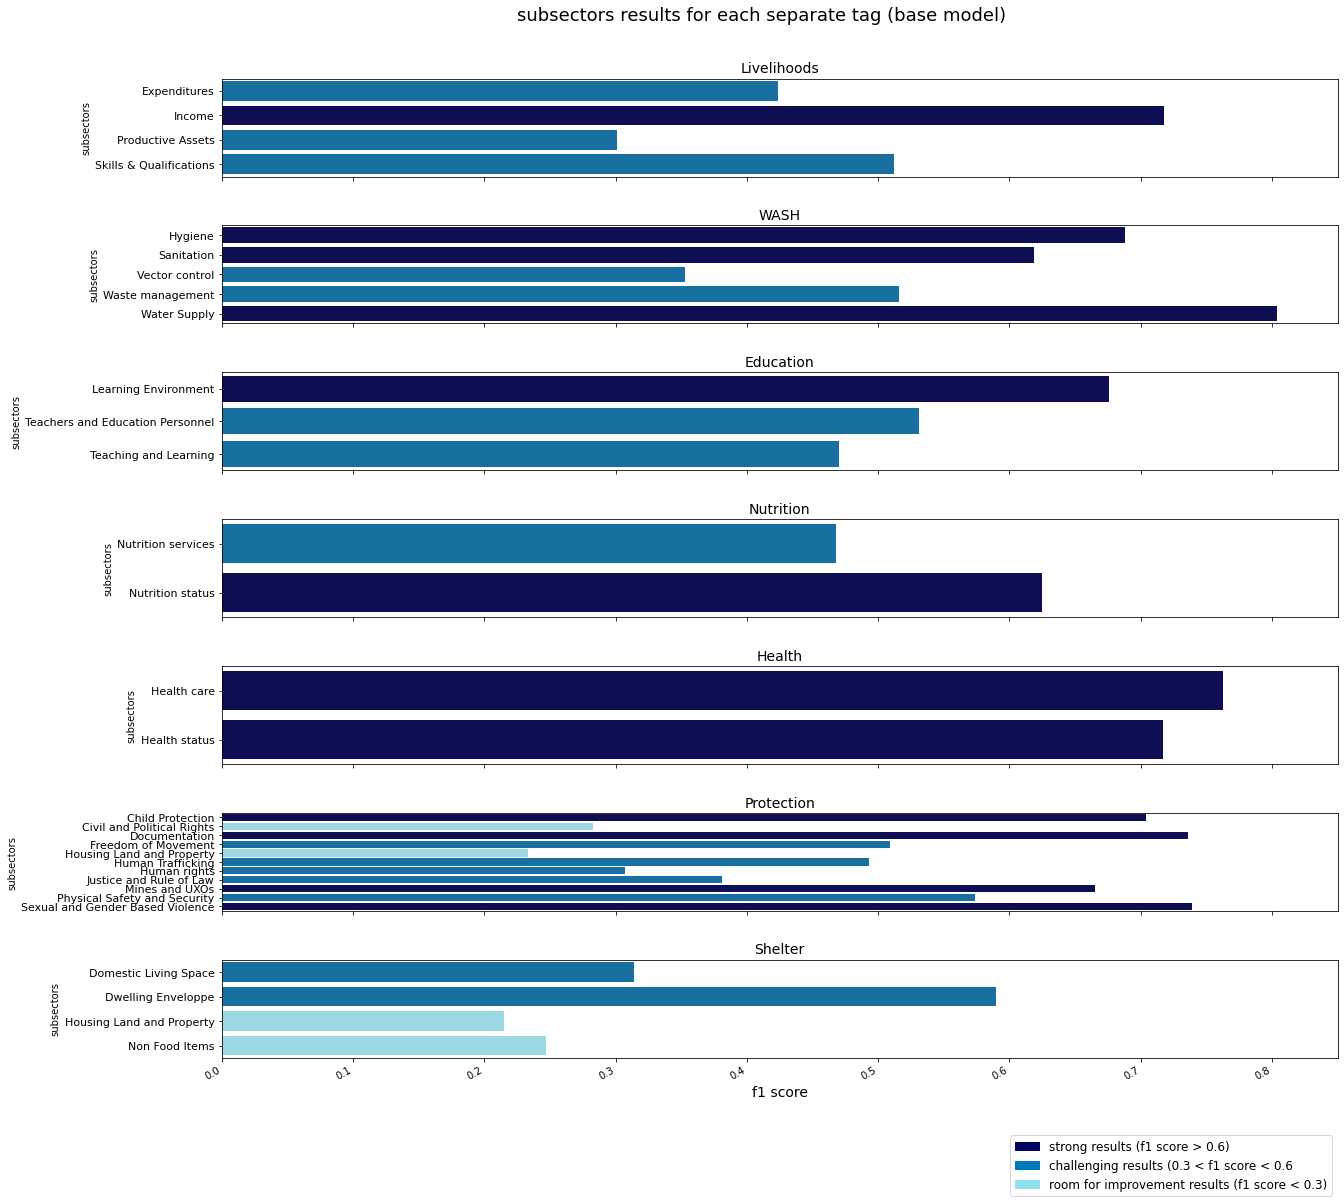

In [15]:
subsectors_vizu_df = results_subsectors.copy()
subsectors_vizu_df.drop(subsectors_vizu_df.tail(1).index,inplace=True)
subsectors_vizu_df.sort_values(by='binary_f1_score', inplace=True, ascending=False)

subsectors_vizu_df = subsectors_vizu_df[['binary_f1_score']]#.rename(columns={'1_f1_score': 'tag reliability'})
subsectors_vizu_df['tag_name'] = subsectors_vizu_df.index
subsectors_vizu_df['sectors'] = subsectors_vizu_df['tag_name'].apply(lambda x: x.split('->')[0])
subsectors_vizu_df['subsectors'] = subsectors_vizu_df['tag_name'].apply(lambda x: x.split('->')[1])

n_treated_sectors = len(sectors_treated)
fig, axes = plt.subplots(n_treated_sectors, 1, sharex=True, figsize=(20,20), facecolor='white')


def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = values 
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

custom_palette = {}
for v in list(subsectors_vizu_df['subsectors']):
    q = subsectors_vizu_df[subsectors_vizu_df['subsectors']==v]['binary_f1_score'].values[0]
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_sectors = {
 'WASH': 1,
 'Livelihoods': 0,
 'Nutrition': 3,
 'Health': 4,
 'Protection': 5,
 'Shelter': 6,
 'Education': 2
}

for j in range (n_treated_sectors):
    sector_tmp = sectors_treated[j]
    i = ordered_sectors[sector_tmp]
    subsectors_tmp = results_subsectors[results_subsectors.index.to_series().apply(
        lambda x: x.split('->')[0] == sector_tmp
    )]
    
    y = subsectors_tmp['binary_f1_score']
    subsectors_tmp['subsectors'] = subsectors_tmp.index.to_series().apply(lambda x: x.split('->')[1])

    axes[i].set_title(f'{sector_tmp}', fontsize=14)
    plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].set_xlim([0, 0.85])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=subsectors_tmp['subsectors'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]
fig.suptitle('subsectors results for each separate tag (base model)', fontsize=18, y=0.93)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0.1))


plt.savefig('subsectors_vizu/big_model_vizu.png', bbox_inches="tight")


In [ ]:
#assertion to not rerun fasttext models
assert(1==2)

## Fasttext baseline

In [22]:
DATA_PATH = os.path.join(
   '..', '..', '..', '..', "data", "frameworks_data", 'subsectors', 'training_data'
)

train_val_df = pd.read_csv(os.path.join(DATA_PATH, 'train_subsectors.csv')).drop_duplicates()
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_subsectors.csv'))

train_val_df['target'] = train_val_df['target'].apply(literal_eval)
test_df['target'] = test_df['target'].apply(literal_eval)

In [23]:
def custom_stratified_train_test_split(df, ratios={'train': 0.85, 'val': 0.15}):
    """
    custom function for stratified train test splitting
    1) take unique sub-tags (example: ['Health'])
    2) For each unique subtag:
        i) take all indexes that have that specific subtag
        ii) split them randomly to train and test sets
    """
    train_ids = []
    val_ids = []
    positive_df = df.copy()
    positive_df["target"] = positive_df["target"].apply(str)
    ids = positive_df.groupby("target")["entry_id"].agg(list).values
    unique_ids = [list(np.unique(list_)) for list_ in ids]

    for ids_entry in unique_ids:

        train_ids_entry = random.sample(
            ids_entry, int(len(ids_entry) * ratios["train"])
        )
        val_ids_entry = list(set(ids_entry) - set(train_ids_entry))

        train_ids.append(train_ids_entry)
        val_ids.append(val_ids_entry)

    return flatten(train_ids), flatten(val_ids)

train_ids, val_ids = custom_stratified_train_test_split(train_val_df)

In [24]:
train_df = train_val_df[train_val_df.entry_id.isin(train_ids)]
val_df = train_val_df[train_val_df.entry_id.isin(val_ids)]

labels_train = list(set(flatten(train_df.target)))
labels_val = list(set(flatten(val_df.target)))
labels_test = list(set(flatten(test_df.target)))

len(labels_train), len(labels_val), len(labels_test)

(31, 31, 31)

In [25]:
def clean_sentence(x):
    x = x.replace("\n", " ")
    x = x.translate(str.maketrans(' ', ' ', string.punctuation))
    return x

def prepare_data(df, column, filename=None):
    if not os.path.exists("./fast_data"):
        os.makedirs("./fast_data")
    total = []
    text = [c.strip().lower() for c in df.excerpt]
    target = [[a.strip().lower().replace(" ", "*") for a in c] if c else ["NEGATIVE"] for c in df[column].tolist()]
    for x, y in zip(text, target):
        x = clean_sentence(x)
        labels = " ".join([f"__label__{c}" for c in y])
        total.append(" ".join([labels, x]))
        
    a =  "\n".join(total)
    with open(f"./fast_data/{filename}", "w+") as f:
        f.write(a)

In [27]:
#prepare data to train fasttext models
prepare_data(train_df, "target", "fasttextdata.train")
prepare_data(val_df, "target", "fasttextdata.val")
prepare_data(test_df, "target", "fasttextdata.test")

#train model
model = fasttext.train_supervised(input="./fast_data/fasttextdata.train",
                                  autotuneValidationFile="./fast_data/fasttextdata.val",
                                  thread=1,
                                  loss="ova" #one-vs-all loss
                                  )

In [28]:
def get_pred(filename, model, thres = 0.5):
    """
    function used to get predictions using fasttext models
    """
    tot = []
    test = open(filename, "r").read().split("\n")
    for s in test:
        labels = [c for c in s.split() if "__label__" in c]
        ss = " ".join([c for c in s.split() if "__label__" not in c]).strip()
        pred = model.predict(ss, k=-1, threshold=thres)
        lab = [c.replace("__label__","").replace("*", " ") for c in pred[0] if not "NEGATIVE" in c]
        tot.append(lab)
    return tot

In [29]:
predictions = get_pred("./fast_data/fasttextdata.test", model)

In [38]:
groundtruth = [[c.lower() for c in a] for a in test_df.target]
subtags = [c.lower() for c in labels_test]

results_df = assess_performance (predictions, groundtruth, subtags, 'all_tags')

#round results
for column in results_df.columns:
    results_df[column] = results_df[column].round(decimals = 2)

results_df.index = results_df.index.to_series().apply(
    lambda x: "->".join(x.split("->")[1:]) if "->" in x else x
)
results_df = results_df.sort_index()

bool_index_not_mean = results_df.index.to_series().apply(lambda x: '->' in x)
subsectors_results = results_df[bool_index_not_mean]
subsectors_results.index = subsectors_results.index.to_series().apply(lambda x: x.split('->')[1])

results_df = pd.concat([
    subsectors_results,
    results_df[~bool_index_not_mean]
])
results_df

,binary_precision,binary_recall,binary_f1_score
learning environment,0.73,0.38,0.50
teachers and education personnel,0.10,0.00,0.01
teaching and learning,0.36,0.07,0.12
health care,0.81,0.56,0.66
health status,0.81,0.54,0.64
expenditures,0.50,0.00,0.00
income,0.79,0.54,0.64
productive assets,0.00,0.00,0.00
skills & qualifications,0.75,0.01,0.02
nutrition services,0.12,0.00,0.01
